<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
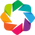

Initializing Julia interpreter. This may take some time...


In [1]:
import numpy as np
import holoviews as hv; hv.extension('bokeh')
import panel as pn;     pn.extension()
from panel.interact import interact

from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main

%load_ext julia.magic

In [ ]:
%%julia
using Pkg, Revise
gla_dir = "../GenLinAlgProblems"
Pkg.activate(gla_dir)
using GenLinAlgProblems, LinearAlgebra, RowEchelon, LaTeXStrings, Latexify, Markdown, Printf

using PyCall
py_display = pyimport("IPython.display").display
py_Latex   = pyimport("IPython.display").Latex

function py_show(args...; kwargs...)  py_display(py_Latex(l_show(args...; kwargs...))) end;

In [26]:
%%julia
using Random
function gen_nilpotent_matrix(n::Int; maxint=3, max_subdiags=n-1)
    P, P_inv = gen_inv_pb(n, maxint=maxint)
    num_subdiags = rand(1:max_subdiags)
    N = [ (i > j && i - j <= num_subdiags) ? rand(-maxint:maxint) : 0 for i in 1:n, j in 1:n ]
    A = P * N * P_inv
end;

<div style="float:center;width:100%;text-align:center;">
<strong style="height:100px;color:darkred;font-size:40px;">Nilpotent Matrices and Their Applications</strong><br>
</div>

# 1. Introduction

## 1.1 Definition and Importance of Nilpotent Matrices

<div style="float:left;width:100%;background-color:#F2F5A9;color:black;">

**Definition:** A matrix $A$ is **nilpotent** if there exists a positive integer $k$ such that $A^k = 0.$<br>
$\qquad$ The smallest such $k$ is called the **nilpotency index** of the matrix.
</div>

For example, the following matrix $A$ is nilpotent with a nilpotency index of 3:

In [7]:
%%julia
A  = [0 1 0 0; 0 0 1 0; 0 0 0 1; 0 0 0 0]
A2 = A^2
A3 = A2 * A
A4 = A3 * A

py_show( L"A =", A, L"\qquad A^2 =", A2, L"\qquad A^3 =", A3, L"\qquad A^4 =", A4 )

<IPython.core.display.Latex object>

____
Let us write an *is_nilpotent()* function and test it

In [30]:
%%julia
function is_nilpotent(matrix::AbstractMatrix, max_power::Int=10)
    powers        = [matrix]  # Initialize list to store intermediate powers
    current_power = matrix

    for k in 2:max_power
        current_power = current_power * matrix
        push!(powers, current_power)
        if norm(current_power) ≈ 0.0  # Check if the matrix is close to zero
            return (true, k, powers)
        end
    end

    return (false, nothing, powers)  # returns true/false, index of nilpotency, matrix powers
end;

In [63]:
%%julia
function tst(n=3)
    for _ in 1:3
        _,_ndx,m_list = is_nilpotent( gen_nilpotent_matrix(3))
        
        powers = []
        for i in 1:_ndx  push!( powers, l_show(L"\quad A^{%$(i-1)} =", m_list[i])) end
        py_show(powers...)
    end
end
tst()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [179]:
def visualize_nilpotent_matrix(powers,ok):
    n           = powers[0].shape[0]
    ndx         = len(powers)
    abs_powers  = [np.abs(power) for power in powers]
    # max_val     = max(*[np.max(abs_powers[k]) for k in range(ndx)],1e-6)
    max_val     = max(np.max(abs_powers[0]), 1e-6)
    epsilon     = max_val * 1e-3  # Small fraction of max_val to create a gap
    color_range = (-epsilon, max_val)  # Widen the range to ensure zero is distinct

    heatmaps = {
        k : hv.HeatMap((range(n), range(n), abs_powers[k]))\
                    .opts(xticks=None, yticks=None, title = f"A^{k}")
        for k in range(ndx)
    }
 
    dmap = hv.DynamicMap(
        lambda i: heatmaps[i], kdims=["Power"]
    ).redim.values(Power=list(range(0, ndx)))

    return dmap.opts( width=300, height=300, colorbar=True, cmap="plasma", clim=color_range,
        tools=["hover"]
    )
ok,_,powers = Main.is_nilpotent( Main.gen_nilpotent_matrix(10))
if not ok:
    print( "Did not converge" )
else:
    display(visualize_nilpotent_matrix(powers,ok))

:DynamicMap   [Power]
   :HeatMap   [x,y]   (z)

## 1.2 Importance of Nilpotent Matrices

Nilpotent matrices are a cornerstone of linear algebra, with significant theoretical and practical implications:

1. **Jordan Canonical Form**:
   - Nilpotent matrices form the building blocks of the Jordan canonical form, which represents any square matrix as a sum of a diagonalizable matrix and a nilpotent matrix. Understanding nilpotent matrices is crucial for analyzing the structure of linear operators.

2. **Differential Equations**:
   - When solving systems of differential equations, nilpotent matrices simplify the computation of matrix exponentials \( e^{tA} \). This is particularly useful for matrices with repeated eigenvalues.

3. **Iterative Algorithms**:
   - In numerical methods and iterative algorithms, nilpotent-like structures arise naturally, particularly in the context of Krylov subspaces.

4. **Decompositions**:
   - Many matrix factorizations, like the LU decomposition and singular value decomposition (SVD), involve submatrices that may exhibit nilpotent behavior.

5. **Theoretical Insights**:
   - The properties of nilpotent matrices (e.g., all eigenvalues are zero, trace and determinant are zero) reveal deeper insights into linear transformations and the behavior of square matrices.
  
Nilpotent matrices are important in various fields of mathematics and science, including:
- Understanding matrix decomposition and eigenvalues.
- Applications in differential equations and dynamical systems.
- Connections to Lie algebras and other abstract algebraic structures.

## Key Properties
1. For a nilpotent matrix \( A \), there exists a smallest positive integer \( k \) (called the **index of nilpotency**) such that \( A^k = 0 \).
2. All eigenvalues of a nilpotent matrix are zero.
3. A nilpotent matrix is always singular (non-invertible).
4. Nilpotent matrices play a key role in the Jordan canonical form.

# 3. Constructing Nilpotent Matrices
Random Strictly Upper Triangular Matrices

%%julia
# Function to generate random strictly upper triangular nilpotent matrices
using Random

function generate_nilpotent_matrix(n)
    A = zeros(Int, n, n)
    for i in 1:n, j in i+1:n
        A[i, j] = rand(-5:5)
    end
    return A
end

# Generate a 4x4 nilpotent matrix
B = generate_nilpotent_matrix(4)
B

# 4. Visualizing Nilpotent Matrices
Matrix Powers Heatmap

In [ ]:
%%julia
# Function to compute matrix powers
function matrix_powers(A, max_power)
    powers = [A^k for k in 1:max_power]
    return powers
end

# Compute powers of the matrix B
powers = matrix_powers(B, 5)
powers

# 5. Applications
## Application 1: Jordan Canonical Form

In [ ]:
%%julia
using LinearAlgebra

# Function to compute Jordan canonical form
function jordan_form_example(A)
    F, J = jordan_form(A)
    return F, J
end

# Compute Jordan form for the nilpotent matrix A
F, J = jordan_form_example(A)
(F, J)


## Application 2: Solving Linear Systems

In [ ]:
%%julia
# Function to compute the matrix exponential
using LinearAlgebra

function matrix_exponential(A, t)
    return exp(t * A)
end

# Compute the exponential of A for t = 1.0
t = 1.0
exp_result = matrix_exponential(A, t)
exp_result

### Exercises
1. Prove that any strictly upper triangular matrix is nilpotent.
2. Compute the nilpotency index of the following matrix using Julia:
   \[
   C = \begin{bmatrix} 0 & 1 & 2 \\ 0 & 0 & 1 \\ 0 & 0 & 0 \end{bmatrix}
   \]
3. Write a Julia function to verify if a given matrix is nilpotent and determine its nilpotency index.
4. Use Julia to generate a random nilpotent matrix of size \( n = 5 \) and verify its properties.


## 7. Conclusion

### Conclusion
In this notebook, we explored nilpotent matrices using Julia for computations and Python for visualization. These matrices are fundamental in linear algebra and have significant applications in solving linear systems, understanding Jordan canonical forms, and iterative algorithms.

**Key Takeaways**:
- All eigenvalues of a nilpotent matrix are zero.
- Nilpotent matrices simplify computational tasks.
- Python and Julia together provide a powerful framework for exploring advanced linear algebra topics.

Continue experimenting with the exercises and exploring further applications!